In [1]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2,torchvision
from timm.loss import SoftTargetCrossEntropy
from timm.data.mixup import Mixup
from timm.scheduler import CosineLRScheduler
from timm.optim.optim_factory import create_optimizer_v2
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
from tqdm.auto import tqdm
from fastprogress.fastprogress import format_time
from ranger.ranger2020 import Ranger
from timm import utils

In [2]:
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

## Config

In [19]:
DATA_PATH = Path('/data/')
CSV_PATH = DATA_PATH/'train.csv'
FOLD_PATH = DATA_PATH/'train_folds.csv'
IMAGE_FOLDER = DATA_PATH/'train'

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

VERSION = "NB_EXP_V2_008"
MODEL = "tf_efficientnet_b4_ns"
BS = 32
SZ = 448
EP = 15
LR = 3e-04
WD = 0.01

mixup_args = dict(mixup_alpha=0.5, cutmix_alpha=1.0, prob=0.6, switch_prob=0.5, label_smoothing=0.01, num_classes=len(LABELS))

MODEL_FOLDER = Path(f"/runs/{VERSION}/")
MODEL_FOLDER.mkdir(exist_ok=True)

KERNEL_TYPE = f"{MODEL}_{SZ}_bs{BS}_ep{EP}_lr{str(LR).replace('-','')}_wd{str(WD).replace('-','')}_mixup_cutmix"

print(MODEL_FOLDER)
print(KERNEL_TYPE)

/runs/NB_EXP_V2_008
tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix


In [20]:
folds = pd.read_csv(FOLD_PATH)
folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [21]:
class LoadImagesAndLabels(torch.utils.data.Dataset):
    
    def __init__(self, df, transforms, mode='train'):
        self.df = df
        self.transforms = transforms
        self.mode = mode
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self,index):
        row = self.df.iloc[index]
        img_path = str(DATA_PATH/row.image)
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        
        if self.mode == 'test':
            return img
            
        label = torch.tensor(labels_class_map[row.label]).long()
        return img, label

## Augmentations

In [22]:
TRAIN_AUG = A.Compose([
    A.RandomResizedCrop(height=SZ, width=SZ, p=1.0, scale=(0.72, 1.0)),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75),
    A.Normalize(),
    ToTensorV2(),
])

VALID_AUG = A.Compose([
    A.SmallestMaxSize(max_size=SZ + 16, p=1.0),
    A.CenterCrop(height=SZ, width=SZ, p=1.0),
    A.Normalize(),
    ToTensorV2(),
])

## Visualization

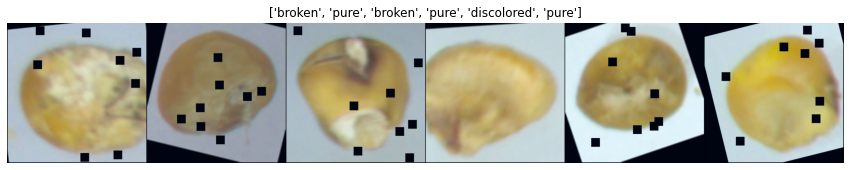

In [23]:
dataset_show = LoadImagesAndLabels(folds, TRAIN_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8), title=[labels_class_map_rev[x] for x in target.numpy()]);

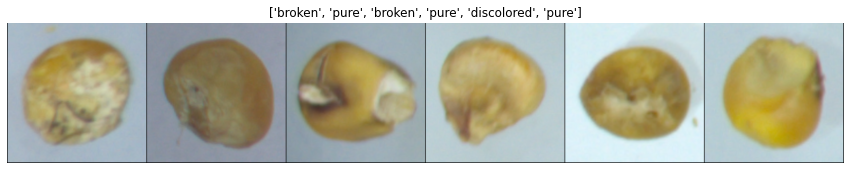

In [24]:
dataset_show = LoadImagesAndLabels(folds, VALID_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8), title=[labels_class_map_rev[x] for x in target.numpy()]);

## Model

In [25]:
def get_corn_model(model_name, pretrained=True, **kwargs):
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, len(LABELS)))
    return model

## Train & Validation Function¶

In [26]:
def train_one_epoch(
    model: nn.Module,
    loader: Iterable,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    mixup_fn: Callable = None,
    grad_scaler: torch.cuda.amp.GradScaler = None,
    mbar: master_bar = None,
):

    model.train()

    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        input, target = mixup_fn(input, target)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(input)
            loss = loss_fn(output, target)

        losses_m.update(loss.item(), input.size(0))

        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(batch_idx + 1)
        pbar.comment = f"{losses_m.avg:.4f}"

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg)])


@torch.inference_mode()
def validate(model: nn.Module, loader: Iterable, loss_fn: Callable, mbar: master_bar):
    model.eval()

    accs_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        output = model(input)

        loss = loss_fn(output, target).item()
        losses_m.update(loss, input.size(0))

        acc = accuracy(output, target).item()
        accs_m.update(acc, output.size(0))

        pbar.update(batch_idx + 1)

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg), ("accuracy", accs_m.avg)])

## Run!

In [27]:
def training_loop(fold):
    with IPyExperimentsPytorch(cl_set_seed=42):
        print()
        print("*" * 100)
        print(f"Training fold {fold}")
        print("*" * 100)

        torch.backends.cudnn.benchmark = True

        dataset_train = LoadImagesAndLabels(folds.query("fold!=@fold"), transforms=TRAIN_AUG, mode="train")
        dataset_valid = LoadImagesAndLabels(folds.query("fold==@fold"), transforms=VALID_AUG, mode="valid")

        print(f"TRAIN: {len(dataset_train)} | VALID: {len(dataset_valid)}")

        loader_train = torch.utils.data.DataLoader(dataset_train, BS, num_workers=8, shuffle=True, drop_last=True)
        loader_valid = torch.utils.data.DataLoader(dataset_valid, BS * 2, num_workers=8, shuffle=False)

        model = get_corn_model(MODEL, pretrained=True, drop_path_rate=0.3)
        model.cuda()

        optimizer = create_optimizer_v2(model, "adamw", lr=LR, weight_decay=WD)

        num_train_steps = len(loader_train) * EP
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_train_steps)

        mixup = Mixup(**mixup_args)

        train_loss_fn = SoftTargetCrossEntropy()
        valid_loss_fn = nn.CrossEntropyLoss()

        grad_scaler = torch.cuda.amp.GradScaler()

        print(f"Scheduled epochs: {EP}")

        mbar = master_bar(list(range(EP)))
        best_epoch, best_metric = 0, 0
        metric_names = ["epoch", "train_loss", "valid_loss", "accuracy", "time"]
        mbar.write([f"{l:.6f}" if isinstance(l, float) else str(l) for l in metric_names], table=True)

        for epoch in range(EP):
            start_time = time.time()
            mbar.update(epoch)

            train_metrics = train_one_epoch(
                model, loader_train, train_loss_fn, optimizer,
                lr_scheduler=lr_scheduler, mixup_fn=mixup, grad_scaler=grad_scaler, mbar=mbar)

            valid_metrics = validate(model, loader_valid, valid_loss_fn, mbar=mbar)
            
            elapsed = format_time(time.time() - start_time)
            epoch_log = [epoch,train_metrics["loss"], valid_metrics["loss"], valid_metrics["accuracy"], elapsed]
            mbar.write([f"{l:.6f}" if isinstance(l, float) else str(l) for l in epoch_log], table=True)

            if valid_metrics["accuracy"] > best_metric:
                best_epoch, best_metric = epoch, valid_metrics["accuracy"]
                dirpath = MODEL_FOLDER / (KERNEL_TYPE + f"_CV_{fold}.pth")
                torch.save(model.state_dict(), dirpath)

        mbar.on_iter_end()
        print("*** Best metric: {0} (epoch {1})".format(best_metric, best_epoch))

In [28]:
for fold_idx in range(5):
    training_loop(fold_idx)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   1,681  11,273  15,897 MB  10.58% 
GPU:   1,133  23,442  24,576 MB   4.61% 



****************************************************************************************************
Training fold 0
****************************************************************************************************
TRAIN: 11457 | VALID: 2865
Scheduled epochs: 15


epoch,train_loss,valid_loss,accuracy,time
0,0.986624,0.683153,0.736824,02:04
1,0.867105,0.636112,0.750785,01:57
2,0.831992,0.569702,0.771030,01:57
3,0.803514,0.580398,0.776963,01:57
4,0.795693,0.544977,0.786736,01:57
5,0.748368,0.568547,0.771030,01:57
6,0.752867,0.530357,0.784642,01:57
7,0.710669,0.526119,0.785689,01:58
8,0.718503,0.535284,0.798255,01:58
9,0.695672,0.515994,0.787784,01:58


*** Best metric: 0.8038394413277324 (epoch 13)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:29:40.324
･ CPU:      1,934        147      3,616 MB |
･ GPU:     12,226      7,520     13,359 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:29:41 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:    1,934        0 MB (  0.00%)
GPU:   12,226        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,616   9,709  15,897 MB  22.75% 
GPU:  13,359  11,216  24,576 MB  54.36% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,616   9,709  15,897 MB  22.75% 
GPU:   1,839  22,736  24,576 MB   7.49% 



****************************************************************************************************
Training fold 1
********************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.995433,0.658987,0.743805,01:58
1,0.859591,0.598532,0.756021,01:58
2,0.825866,0.600853,0.754276,01:58
3,0.800346,0.569172,0.769284,01:58
4,0.795255,0.554115,0.774869,01:58
5,0.752634,0.543715,0.776963,01:58
6,0.758018,0.535218,0.787086,01:58
7,0.702726,0.525459,0.790925,01:58
8,0.713441,0.525996,0.791274,01:58
9,0.691484,0.498207,0.798953,01:58


*** Best metric: 0.802792320742449 (epoch 13)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:29:40.016
･ CPU:         65        147      3,682 MB |
･ GPU:      1,580     21,058      3,419 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:29:40 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:       65        0 MB (  0.00%)
GPU:    1,580        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,682   9,642  15,897 MB  23.16% 
GPU:   3,419  21,156  24,576 MB  13.91% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,681   9,642  15,897 MB  23.16% 
GPU:   1,839  22,736  24,576 MB   7.49% 



****************************************************************************************************
Training fold 2
*********************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,1.008831,0.669344,0.743715,01:59
1,0.862096,0.619142,0.757332,01:58
2,0.823610,0.598946,0.766411,01:58
3,0.787396,0.571545,0.771648,01:58
4,0.789253,0.589216,0.771299,01:58
5,0.753361,0.582125,0.775838,01:58
6,0.761457,0.561424,0.782123,01:58
7,0.696026,0.542808,0.780726,01:58
8,0.714918,0.546409,0.792947,01:58
9,0.688364,0.525250,0.796089,01:58


*** Best metric: 0.797486033519553 (epoch 13)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:29:39.950
･ CPU:          1        147      3,683 MB |
･ GPU:      1,582     21,032      3,421 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:29:40 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:        1        0 MB (  0.00%)
GPU:    1,582        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,682   9,640  15,897 MB  23.17% 
GPU:   3,421  21,154  24,576 MB  13.92% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,682   9,640  15,897 MB  23.17% 
GPU:   1,839  22,736  24,576 MB   7.49% 



****************************************************************************************************
Training fold 3
*********************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.993111,0.684040,0.723115,01:58
1,0.867774,0.598984,0.752444,01:58
2,0.828503,0.575619,0.778282,01:58
3,0.802330,0.542653,0.785615,01:58
4,0.796638,0.544675,0.783170,01:58
5,0.756406,0.540216,0.791201,01:58
6,0.770621,0.526944,0.797137,01:58
7,0.706943,0.525302,0.797137,01:58
8,0.721347,0.521433,0.798534,01:58
9,0.696352,0.484332,0.810754,01:58


*** Best metric: 0.8118016759776536 (epoch 11)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:29:39.695
･ CPU:          0        147      3,683 MB |
･ GPU:      1,580     21,058      3,419 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:29:40 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:        0        0 MB (  0.00%)
GPU:    1,580        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,683   9,655  15,897 MB  23.17% 
GPU:   3,419  21,156  24,576 MB  13.91% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,683   9,655  15,897 MB  23.17% 
GPU:   1,839  22,736  24,576 MB   7.49% 



****************************************************************************************************
Training fold 4
********************************************************************

epoch,train_loss,valid_loss,accuracy,time
0,0.995029,0.663394,0.748603,01:58
1,0.862650,0.627562,0.750698,01:58
2,0.828846,0.579412,0.772696,01:58
3,0.808107,0.547318,0.789804,01:58
4,0.799471,0.575565,0.778980,01:58
5,0.768120,0.556144,0.787709,01:58
6,0.768536,0.513312,0.806913,01:58
7,0.715822,0.520985,0.803073,01:58
8,0.719254,0.514905,0.803771,01:58
9,0.696491,0.482834,0.812500,01:58


*** Best metric: 0.8187849165341041 (epoch 11)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:29:37.669
･ CPU:          0        146      3,682 MB |
･ GPU:      1,580     21,034      3,419 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:29:38 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:        0        0 MB ( -0.00%)
GPU:    1,580        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,682   9,631  15,897 MB  23.17% 
GPU:   3,419  21,156  24,576 MB  13.91% 




In [29]:
MODEL_FOLDER.ls()

(#5) [Path('/runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_4.pth'),Path('/runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_0.pth'),Path('/runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_2.pth'),Path('/runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_3.pth'),Path('/runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_1.pth')]

In [30]:
folds_val_score = []
for fold in range(5):
    CHECKPOINT = MODEL_FOLDER/(KERNEL_TYPE + f"_CV_{fold}.pth")
    print(f'=> load from : {CHECKPOINT}')
    
    model = get_corn_model(MODEL, pretrained=False)
    model.load_state_dict(torch.load(CHECKPOINT))
    model.eval()
    model.cuda()
    
    dataset_valid = LoadImagesAndLabels(folds.query('fold==@fold'), transforms=VALID_AUG, mode="valid")
    loader_valid = torch.utils.data.DataLoader(dataset_valid, BS*2, num_workers=8, shuffle=False)
    
    preds, targs = [],[]
    for input,target in tqdm(loader_valid, total=len(loader_valid), dynamic_ncols=True):
        with torch.cuda.amp.autocast(), torch.no_grad():
            input = input.cuda()
            
            output  = model(input)
            output += model(torch.flip(input, dims=(3,)))
            output += model(torch.flip(input, dims=(2,)))
            output += model(torch.flip(input, dims=(2,3)))
            
        preds.append(output.data.cpu())
        targs.append(target)
    
    preds = torch.cat(preds)
    targs = torch.cat(targs)
    
    acc = accuracy(preds, targs).item()
    print(f"* Accuracy : {acc}")
    print()
        
    folds_val_score.append(acc)
    
    
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

=> load from : /runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_0.pth


  0%|                                                                                                         …

* Accuracy : 0.8076788783073425

=> load from : /runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_1.pth


  0%|                                                                                                         …

* Accuracy : 0.802443265914917

=> load from : /runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_2.pth


  0%|                                                                                                         …

* Accuracy : 0.8093575239181519

=> load from : /runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_3.pth


  0%|                                                                                                         …

* Accuracy : 0.8114525079727173

=> load from : /runs/NB_EXP_V2_008/tf_efficientnet_b4_ns_448_bs32_ep15_lr0.0003_wd0.01_mixup_cutmix_CV_4.pth


  0%|                                                                                                         …

* Accuracy : 0.8219273686408997


****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80768, 0.80244, 0.80936, 0.81145, 0.82193]
Avg: 0.81057
Std: 0.00641
